In [40]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import parameter
from torch.utils import data
from torchvision import transforms
import random
from d2l import torch as d2l

# 线性回归从零开始

### 生成数据集

In [41]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, size=(num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, size=y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([1.8037, 0.0207]) 
label: tensor([7.7242])


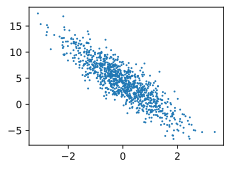

In [42]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

上面的 `.detach()` 是为了将数据从计算图中取出。

### 读取数据集

In [43]:
def data_iter(batch_size, features, label):
    num_example = len(features)
    index = list(range(num_example))
    random.shuffle(index)
    for i in range(num_example):
        batch_index = index[i: min(i + batch_size, num_example)]
        batch_index = torch.tensor(batch_index)
        yield features[batch_index], label[batch_index]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.9728, -0.8325],
        [ 1.7128, -0.5654],
        [ 0.7597,  0.4377],
        [-0.9202,  0.5777],
        [-1.4750, -0.4357],
        [ 2.5540,  0.4850],
        [-0.0861,  0.2187],
        [ 0.6028,  0.6944],
        [-0.2956,  0.5773],
        [ 1.8275,  1.2920]]) 
 tensor([[8.9704],
        [9.5228],
        [4.2445],
        [0.3880],
        [2.7354],
        [7.6720],
        [3.2815],
        [3.0379],
        [1.6627],
        [3.4587]])


### 初始化模型

In [44]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(size=(1,), requires_grad=True)

定义网络

In [45]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

定义损失函数

In [46]:
def squared_loss(y_hat, y):
    return 1 / 2 * (y_hat - y.reshape(y_hat.shape)) ** 2

定义优化算法

In [47]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 训练

In [48]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [49]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(y, net(X, w, b))
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000050
epoch 2, loss 0.000050
epoch 3, loss 0.000050


# 线性回归的简洁实现

### 生成数据集

In [50]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 读取数据集

In [51]:
def load_array(data_array, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_array) # TensorDateset是Dataset的子类，专门用于管理Tensor数据类型
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [52]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[ 0.1533,  0.5644],
         [ 0.0782, -0.4810],
         [ 1.1132, -0.6076],
         [-2.0266,  0.4462],
         [-0.8123,  0.7026],
         [-1.5413,  1.9222],
         [-0.8489,  1.6735],
         [-1.5399, -0.5908],
         [-0.1936,  0.7193],
         [ 1.8093, -1.4023]]),
 tensor([[ 2.6102],
         [ 6.0129],
         [ 8.4875],
         [-1.3725],
         [ 0.1559],
         [-5.4031],
         [-3.1806],
         [ 3.1089],
         [ 1.3593],
         [12.5827]])]

### 定义模型

In [53]:
net = nn.Sequential(nn.Linear(2, 1))
net[0].weight.data.normal_(0, 0.01) # net[0]表示取net中的第一层
net[0].bias.data.zero_()

tensor([0.])

In [54]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr = 0.03)

### 训练

In [55]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        trainer.zero_grad()
        l = loss(y, net(X))
        l.backward()
        trainer.step()
    with torch.no_grad():
        l = loss(net(features), labels)
        print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000236
epoch 2, loss 0.000102
epoch 3, loss 0.000103


In [56]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 0.0002, -0.0006])
b的估计误差： tensor([0.0001])


# 图像分类数据集

### 读取数据集

In [57]:
d2l.use_svg_display()

In [58]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=trans, download=True)
mnist_valid = torchvision.datasets.FashionMNIST(root='../data', train=False, transform=trans, download=True)

In [59]:
print(len(mnist_train), len(mnist_valid))
print(mnist_train[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


可以看出，fashion-mnist的训练集和验证机的数量分别为 $60000$ 和 $10000$，同时一张图片的形状为 $[1, 28, 28]$，表示一个通道，以及宽和高都为 $28$。
`mnist_train[0]` 为一个 `tuple`，第一个元素为输入图片，第二个为 `label`

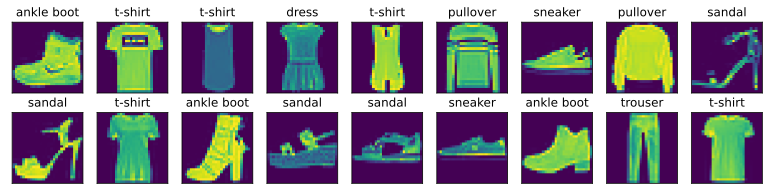

In [60]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18))) # 选了第一个batch
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

### 读取小批量

In [61]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

然后查看读取一个数据集所需的时间

In [62]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'1.80 sec'

### 整合

In [63]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(root='../data/', train=True, transform=trans, download=True)
    mnist_valid = torchvision.datasets.FashionMNIST(root='../data/', train=False, transform=trans, download=True)

    train_iter = data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers())
    valid_iter = data.DataLoader(dataset=mnist_valid, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers())

    return (train_iter, valid_iter)

In [64]:
train_iter, valid_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# softmax回归的从零开始实现 

### 初始化模型参数

In [65]:
batch_size = 256
train_iter, valid_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

num_input = 28 * 28 # 将一张图片变成一个向量
num_output = 10 # 分类的数量

W = torch.normal(0, 0.01, size=(num_input, num_output), requires_grad=True)
b = torch.zeros(size=(num_output,), requires_grad=True)

### 定义softmax操作

In [66]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [67]:
def soft_max(x):
    x_exp = torch.exp(x)
    partition = x_exp.sum(1, keepdim=True)
    return x_exp / partition

In [68]:
X = torch.normal(0, 1, size=(2, 5))
X_prob = soft_max(X)
X_prob, X_prob.sum(1)

(tensor([[0.4088, 0.0849, 0.0991, 0.2724, 0.1348],
         [0.0353, 0.1906, 0.1541, 0.3806, 0.2393]]),
 tensor([1., 1.]))

### 定义模型

In [69]:
def net(X):
    return soft_max(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [70]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y] # 一种方便的索引方式，[0, 1]应该只要是iterator就行

tensor([0.1000, 0.5000])

In [71]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

### 分类精度

In [72]:
def correct_num(y_hat, y):
    y_hat = y_hat.argmax(dim=1)
    cmp = y_hat == y
    return float(cmp.sum())

correct_num(y_hat, y) / len(y)

0.5

In [73]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, nn.Module):
        net.eval()
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            # metric.add(correct_num(net(X), y), len(y))
            metric.add(correct_num(net(X), y), y.numel())
    return metric[0] / metric[1]

evaluate_accuracy(net, valid_iter)

0.1449

# softmax的简洁实现

### 初始化模型参数

In [74]:
batch_size = 256
train_iter, valid_iter = d2l.load_data_fashion_mnist(batch_size)

net = nn.Sequential(nn.Flatten(), nn.Linear(28 * 28, 10))

def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weight)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [76]:
# loss = nn.CrossEntropyLoss(reduction='none')
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)
num_epochs = 10


for epoch in range(num_epochs):
    net.train()
    for X, y in train_iter:
        trainer.zero_grad()
        l = loss(net(X), y)
        l.backward()
        trainer.step()
    print("train_acc={:.3f}, valid_acc={:.3f}".format(evaluate_accuracy(net, train_iter), evaluate_accuracy(net, valid_iter)))

train_acc=0.818, valid_acc=0.803
train_acc=0.810, valid_acc=0.797
train_acc=0.826, valid_acc=0.814
train_acc=0.841, valid_acc=0.829
train_acc=0.843, valid_acc=0.829
train_acc=0.841, valid_acc=0.825
train_acc=0.842, valid_acc=0.828
train_acc=0.849, valid_acc=0.834
train_acc=0.850, valid_acc=0.835
train_acc=0.849, valid_acc=0.833
